In [ ]:
print("hello world")

hello world


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"vignesh451845","key":"9a3ef922f86e29ed2cbaa6eed059fc21"}'}

In [ ]:
#create a kaggle directory
!mkdir ~/.kaggles

In [ ]:
#Copy kaggle.json file
!cp kaggle.json ~/.kaggles/

In [ ]:
ls -ltr ~/.kaggles/

total 4
-rw-r--r-- 1 root root 69 Sep 21 11:11 kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images' -p../data/melanoma-skin-cancer-dataset-of-10000-images


Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images
License(s): CC0-1.0
  0% 0.00/98.7M [00:00<?, ?B/s]
100% 98.7M/98.7M [00:00<00:00, 1.35GB/s]


In [ ]:
ls -ltr ../data/melanoma-skin-cancer-dataset-of-10000-images

total 101084
-rw-r--r-- 1 root root 103508268 Mar 29  2022 melanoma-skin-cancer-dataset-of-10000-images.zip


In [ ]:
!unzip ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma-skin-cancer-dataset-of-10000-images.zip -d ../data/melanoma-skin-cancer-dataset-of-10000-images

Streaming output truncated to the last 5000 lines.
  inflating: ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign/melanoma_643.jpg  
  inflating: ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign/melanoma_644.jpg  
  inflating: ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign/melanoma_645.jpg  
  inflating: ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign/melanoma_646.jpg  
  inflating: ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign/melanoma_647.jpg  
  inflating: ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign/melanoma_648.jpg  
  inflating: ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/benign/melanoma_649.jpg  
  inflating: ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train

In [ ]:
!chmod 755 ../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/

In [ ]:
train_dir='../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train'

In [ ]:
test_dir='../data/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test'

In [ ]:
batch_size = 32
img_size = (224, 224)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pandas as pd

In [ ]:
#Load Datasets
train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
)

Found 9605 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False,
)

Found 1000 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

Class Names: ['benign', 'malignant']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Data augmentation for training set
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Apply augmentation to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)

# Prefetch for better performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Compute class weights to solve imbalanced dataset
train_labels = np.concatenate([np.argmax(y, axis=1) for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}


In [ ]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

In [ ]:
input_shape = (224,224,3)
epochs = 20
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(

    monitor='val_loss',  # Watch validation loss
    factor=0.5,           # Reduce LR by 50%
    patience=3,           # Wait 3 epochs before reducing
    verbose=1             # Print updates
)

results = {}

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
def evaluate_model(model, dataset, model_name):
    y_true = np.concatenate([np.argmax(y, axis=1) for x, y in dataset])
    y_pred_probs = model.predict(dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(f"=== Classification Report: {model_name} ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

In [ ]:
cnn_model = build_cnn(input_shape, num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN with EarlyStopping and Class Weights
history = cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping,lr_scheduler,checkpoint])

Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 118s 348ms/step - accuracy: 0.7753 - loss: 7.3185 - val_accuracy: 0.6770 - val_loss: 6.3456 - learning_rate: 0.0010
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 101s 335ms/step - accuracy: 0.8383 - loss: 0.3893 - val_accuracy: 0.8540 - val_loss: 2.1498 - learning_rate: 0.0010
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 138s 321ms/step - accuracy: 0.8382 - loss: 0.3503 - val_accuracy: 0.8240 - val_loss: 3.8231 - learning_rate: 0.0010
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 101s 334ms/step - accuracy: 0.8277 - loss: 0.4394 - val_accuracy: 0.8460 - val_loss: 1.0189 - learning_rate: 0.0010
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 142s 336ms/step - accuracy: 0.8502 - loss: 0.3519 - val_accuracy: 0.8830 - val_loss: 0.8996 - learning_rate: 0.0010
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 103s 341ms/step - accuracy: 0.8482 - loss: 0.3461 - val_accuracy: 0.8900 - val_loss: 0.7080 - learning_rate: 0.0010
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 137s 326ms/step - accura

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
=== Classification Report: CNN ===
              precision    recall  f1-score   support

      benign       0.89      0.93      0.91       500
   malignant       0.93      0.88      0.90       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



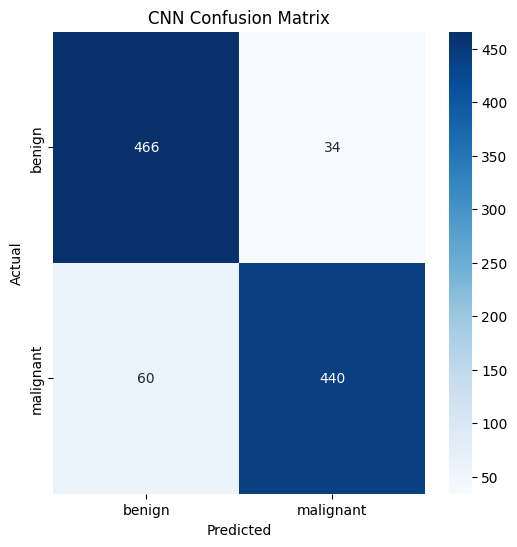

In [ ]:
evaluate_model(cnn_model, test_ds, "CNN")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load pretrained ResNet50 (without the top classification layer)
base_model = ResNet50(
    weights="imagenet",       # pretrained on ImageNet
    include_top=False,        # exclude the final FC layer
    input_shape=(224, 224, 3) # match your image size
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
for layer in base_model.layers[-50:]:
    layer.trainable = True


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),    # flatten features
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(2, activation="sigmoid")  # binary classification (benign vs malignant)
])

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(
    x=train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping,lr_scheduler,checkpoint]

)

Epoch 1/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 153s 409ms/step - accuracy: 0.5252 - loss: 0.7630 - val_accuracy: 0.5000 - val_loss: 1605.9608 - learning_rate: 0.0010
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 104s 344ms/step - accuracy: 0.7865 - loss: 0.4697 - val_accuracy: 0.5250 - val_loss: 10.6608 - learning_rate: 0.0010
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 105s 348ms/step - accuracy: 0.8320 - loss: 0.3970 - val_accuracy: 0.5000 - val_loss: 5.0493 - learning_rate: 0.0010
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 105s 347ms/step - accuracy: 0.8461 - loss: 0.3780 - val_accuracy: 0.5000 - val_loss: 126.6838 - learning_rate: 0.0010
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 104s 344ms/step - accuracy: 0.8515 - loss: 0.3661 - val_accuracy: 0.5000 - val_loss: 50.4788 - learning_rate: 0.0010
Epoch 6/20
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8539 - loss: 0.3501
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
301/301 ━━━━━━━━━━━━━━━━━━━━ 144s 352ms/step - ac

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step
=== Classification Report: CNN ===
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       500
   malignant       0.50      1.00      0.67       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


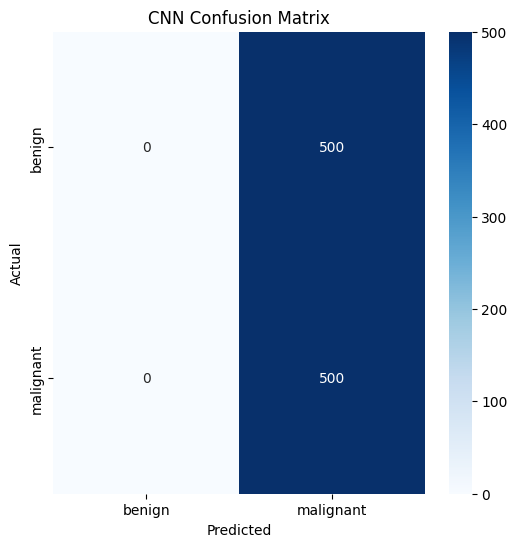

In [ ]:
evaluate_model(model, test_ds, "CNN")